In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import kagglehub
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# downloading the dataset from kaggle
path = kagglehub.dataset_download("sampadab17/network-intrusion-detection")

print("Path to dataset files:", path)

100%|██████████| 818k/818k [00:00<00:00, 93.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sampadab17/network-intrusion-detection/versions/1


In [3]:
train = pd.read_csv(r"/root/.cache/kagglehub/datasets/sampadab17/network-intrusion-detection/versions/1/Train_data.csv")
test = pd.read_csv(r"/root/.cache/kagglehub/datasets/sampadab17/network-intrusion-detection/versions/1/Test_data.csv")

In [4]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# feature groups (FIXED: removed 'class')
non_numerical = ['protocol_type', 'service', 'flag']

numerical = [
    'duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate'
]

# split X / y FIRST (FIXED)
X = train.drop(columns=["class"])
y = train["class"].replace({"anomaly": 0, "normal": 1})

TEST_SIZE = 5000

X_train = X[:-TEST_SIZE]
X_test  = X[-TEST_SIZE:]
y_train = y[:-TEST_SIZE]
y_test  = y[-TEST_SIZE:]

# preprocessing (FIXED: fit only on train)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown="ignore"), non_numerical)
])

X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(len(y_train), len(y_test))


(20192, 118)
(5000, 118)
20192 5000


/tmp/ipython-input-1240559770.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = train["class"].replace({"anomaly": 0, "normal": 1})


In [6]:
##define a simple classification dataset
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(118,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])

model.compile(
    optimizer="rmsprop",
    loss='binary_crossentropy',  # use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        15,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9583 - loss: 0.1409 - val_accuracy: 0.9804 - val_loss: 0.0484
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9849 - loss: 0.0449 - val_accuracy: 0.9881 - val_loss: 0.0375
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9900 - loss: 0.0326 - val_accuracy: 0.9903 - val_loss: 0.0337
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0264 - val_accuracy: 0.9906 - val_loss: 0.0308
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9924 - loss: 0.0269 - val_accuracy: 0.9931 - val_loss: 0.0290
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9923 - loss: 0.0241 - val_accuracy: 0.9903 - val_loss: 0.0359
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9926 - loss: 0.0237 - val_accuracy: 0.9903 - val_loss: 0.0308
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9930 - loss: 0.0205 - val_accuracy: 0.

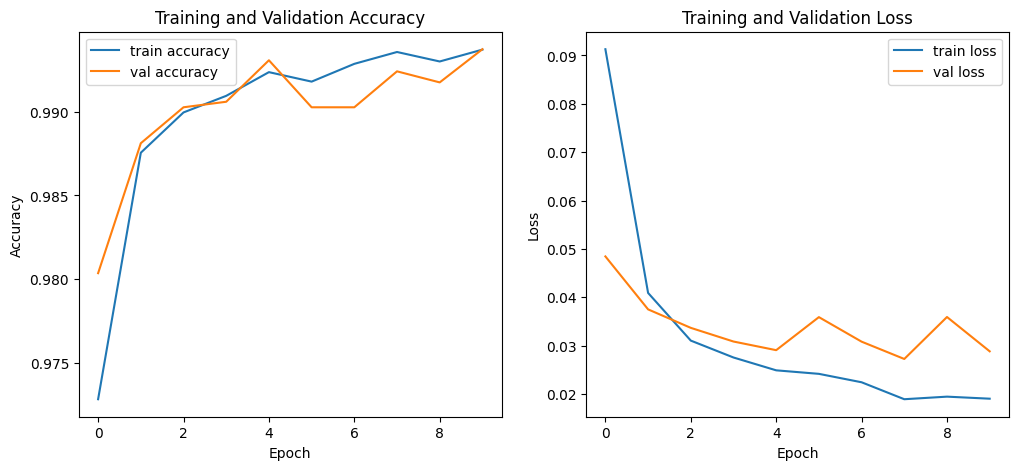

In [7]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.3)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0357
Test Loss: 0.0299
Test Accuracy: 0.9936


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


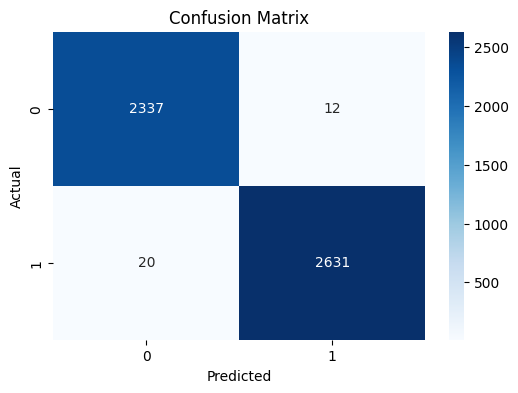

In [15]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
cnf = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,4))
sns.heatmap(c, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()